In [208]:
# paquetes de la implementación
import numpy as np
import gym
import random

# paquetes de las gráficas
import matplotlib.pyplot as plt

In [209]:
# parámetros
alpha = 0.1              # tasa de aprendizaje
gamma = 0.995             # factor de descuento
epsilon = 0.1            # epsilon
n_planning = 5           # planeación
num_episodios = 1500

In [210]:
limites = [
    [-2.4, 2.4],   # x, posición del carrito
    [-2.0, 2.0],   # velocidad del carrito
    [-0.21, 0.21], # theta, ángulo del palo
    [-3.0, 3.0]    # theta_dot, velocidad angular
]

In [211]:
bins_por_variable = [6, 6, 6, 6]

pasos_totales = 0
lista_pasos = []
lista_recompensas = [] 

In [212]:
def discreto(estado):
    """
    Es necesario discretizar el estado ya que es continuo 
    por ello se definió el bins_por_variable, parta generar un espacio discreto
    """
    indices = []
    for i, valor in enumerate(estado):
        min_val, max_val = limites[i] 
        valor_clamp = min(max_val, max(min_val, valor))
        ancho_bin = (max_val - min_val) / bins_por_variable[i]
        indice = int((valor_clamp - min_val) / ancho_bin)
        if indice == bins_por_variable[i]:
            indice = bins_por_variable[i] - 1
        indices.append(indice)
    return tuple(indices)

In [213]:
# tabla Q
q_shape = bins_por_variable + [2] 
Q = np.zeros(q_shape)

# entorno
Model = {}
env = gym.make("CartPole-v1")

In [214]:
for episodio in range(num_episodios):
    obs, _ = env.reset()
    estado_disc = discreto(obs)
    terminado = False
    recompensa_total = 0
    
    while not terminado:
        # epsilon-greedy
        if np.random.rand() < epsilon:
            accion = np.random.randint(2)
        else:
            accion = np.argmax(Q[estado_disc])
        
        
        obs_sig, recompensa, done, truncated, _ = env.step(accion)
        terminado = done or truncated
        recompensa_total = recompensa_total + recompensa
        pasos_totales = pasos_totales + 1
        
        estado_sig_disc = discreto(obs_sig)
        
        # actualizar Q 
        mejor_q_sig = np.max(Q[estado_sig_disc])
        td_error = recompensa + gamma * mejor_q_sig - Q[estado_disc + (accion,)]
        Q[estado_disc + (accion,)] = Q[estado_disc + (accion,)] + alpha * td_error
        Model[(estado_disc, accion)] = (recompensa, estado_sig_disc)
        
        # planeación
        for _ in range(n_planning):
            (s_plan, a_plan) = random.choice(list(Model.keys()))
            (r_plan, s_sig_plan) = Model[(s_plan, a_plan)]
            
            mejor_q_plan = np.max(Q[s_sig_plan])
            td_error_plan = r_plan + gamma * mejor_q_plan - Q[s_plan + (a_plan,)]
            Q[s_plan + (a_plan,)] = Q[s_plan + (a_plan,)] + alpha * td_error_plan
        
        estado_disc = estado_sig_disc
    
    
    lista_recompensas.append(recompensa_total)
    lista_pasos.append(pasos_totales)
    
    # (Opcional) Ajustar epsilon de forma decreciente
    epsilon = max(0.01, epsilon * 0.99)

    if (episodio + 1) % 25 == 0:
        print(f"Episodio {episodio+1}, Recompensa = {recompensa_total}")

env.close()

C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio 25, Recompensa = 19.0
Episodio 50, Recompensa = 10.0
Episodio 75, Recompensa = 106.0
Episodio 100, Recompensa = 26.0
Episodio 125, Recompensa = 10.0
Episodio 150, Recompensa = 14.0
Episodio 175, Recompensa = 9.0
Episodio 200, Recompensa = 15.0
Episodio 225, Recompensa = 11.0
Episodio 250, Recompensa = 13.0
Episodio 275, Recompensa = 14.0
Episodio 300, Recompensa = 13.0
Episodio 325, Recompensa = 14.0
Episodio 350, Recompensa = 13.0
Episodio 375, Recompensa = 13.0
Episodio 400, Recompensa = 14.0
Episodio 425, Recompensa = 12.0
Episodio 450, Recompensa = 13.0
Episodio 475, Recompensa = 14.0
Episodio 500, Recompensa = 11.0
Episodio 525, Recompensa = 12.0
Episodio 550, Recompensa = 12.0
Episodio 575, Recompensa = 14.0
Episodio 600, Recompensa = 12.0
Episodio 625, Recompensa = 14.0
Episodio 650, Recompensa = 9.0
Episodio 675, Recompensa = 12.0
Episodio 700, Recompensa = 10.0
Episodio 725, Recompensa = 15.0
Episodio 750, Recompensa = 10.0
Episodio 775, Recompensa = 14.0
Episodio 800

In [215]:
def promedio(datos, vnv=10): # vnv: para el promedio de los episodios
    return np.convolve(datos, np.ones(vnv)/vnv, mode='valid')

vnv = 10
recompensas_soft = promedio(lista_recompensas, vnv)
pasos_soft = lista_pasos[vnv-1:]  

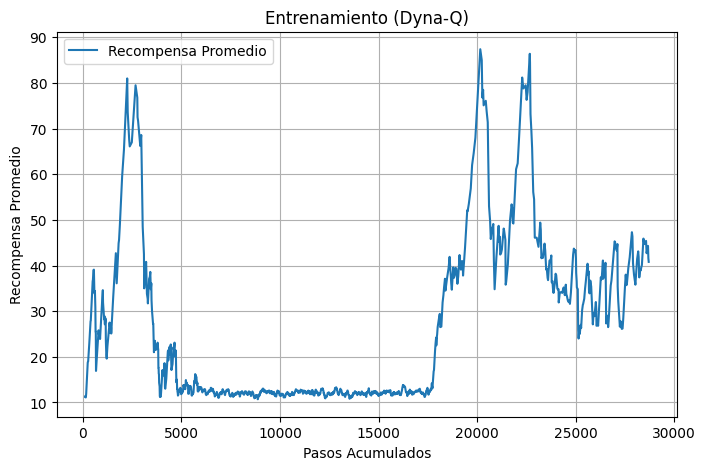

In [ ]:
print("Gráfica de recompensa obtenida.")
print("Eje x: pasos")
print("Eje y : recompensa promedio")
plt.figure(figsize=(8,5))
plt.plot(pasos_soft, recompensas_soft, label=f"Recompensa Promedio")
plt.xlabel("Pasos Acumulados")
plt.ylabel("Recompensa Promedio")
plt.title("Entrenamiento (Dyna-Q)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# corrida sobre 10 experiementos
def eva_politica(env, Q, n_episodios=10):
    recompensas = []
    for _ in range(n_episodios):
        obs, _ = env.reset()
        estado_disc = discreto(obs)
        terminado = False
        recompensa_total = 0
        
        while not terminado:
            # Política greedy
            accion = np.argmax(Q[estado_disc])
            obs_sig, recompensa, done, truncated, _ = env.step(accion)
            terminado = done or truncated
            recompensa_total += recompensa
            estado_disc = discreto(obs_sig)
        
        recompensas.append(recompensa_total)
    return recompensas

# nuevo entorno para evaluación 
env_eval = gym.make("CartPole-v1")

recompensas_eval = eva_politica(env_eval, Q, n_episodios=10)
env_eval.close()

media_recompensa = np.mean(recompensas_eval)
std_recompensa = np.std(recompensas_eval)


print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {std_recompensa:<20.2f} |")
print("----------------------------------------------")



Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | 30.90                |
| Desviación   | 17.77                |
----------------------------------------------
